In [1]:

import numpy as np 
import pandas as pd 


import os


In [2]:
import torch
import torchvision
import torchvision.transforms as TT
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader,random_split
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt
from PIL import Image
from torchvision.datasets import ImageFolder
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline

In [3]:
data_dir='/kaggle/input/preprocessed-snake-images/preprocessed-cleaned-set'

In [4]:
dataset=ImageFolder(data_dir+'/train',transform=ToTensor())

torch.Size([3, 384, 384]) 0


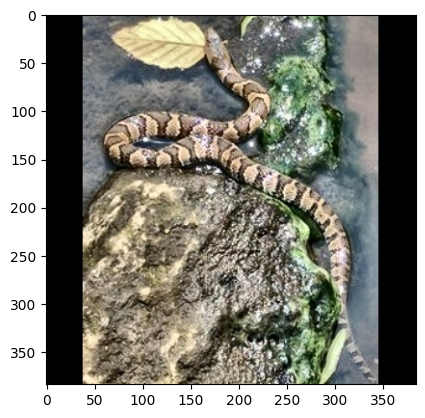

In [5]:
image,label=dataset[501]
print(image.shape,label)
plt.imshow(image.permute(1,2,0))

In [6]:
train_ds,val_ds=random_split(dataset,[15389,2000])

In [7]:
train_dl=DataLoader(train_ds,batch_size=16,shuffle=True,num_workers=3,pin_memory=True)
val_dl=DataLoader(val_ds,batch_size=16,num_workers=3,pin_memory=True)

In [8]:
from torchvision.utils import make_grid

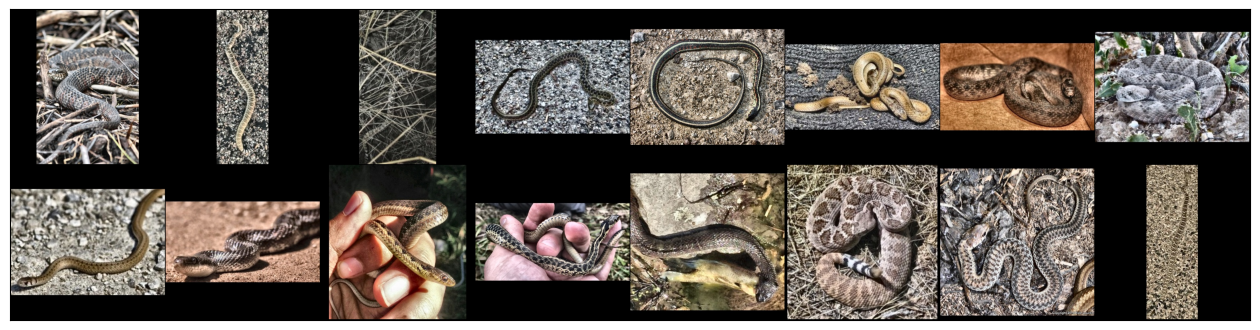

In [9]:
def show_batch(dl):
    for image,label in dl:
        fig,ax=plt.subplots(figsize=(16,16))
        ax.set_xticks([]);ax.set_yticks([])
        ax.imshow(make_grid(image,nrow=8).permute(1,2,0))
        break


show_batch(train_dl)

In [10]:
def accuracy(output,label):
    _,pred=torch.max(output,dim=1)
    return torch.tensor(torch.sum(pred==label).item()/len(pred))


class ImageClassifierBase(nn.Module):
    def training_step(self,batch):
        image,label=batch
        out=self(image)
        loss=F.cross_entropy(out,label)
        return loss

    def validation_step(self,batch):
        image,label=batch
        out=self(image)
        val_loss=F.cross_entropy(out,label)
        val_acc=accuracy(out,label)
        return {'val_loss':val_loss,'val_acc':val_acc}

    def validation_epoch_end(self,output):
        batch_loss=[x['val_loss'] for x in output]
        epoch_loss=torch.stack(batch_loss).mean()
        batch_acc=[x['val_acc'] for x in output]
        epoch_acc=torch.stack(batch_acc).mean()
        return {'val_loss':epoch_loss.item(),'val_acc':epoch_acc.item()}

    def epoch_end(self, epoch, result):
        print("Epoch [{}],{} train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, "last_lr: {:.5f},".format(result['lrs'][-1]) if 'lrs' in result else '', 
            result['train_loss'], result['val_loss'], result['val_acc']))
    @torch.no_grad()
    def evaluate(self,val_dl):
        self.eval()
        output=[self.validation_step(batch) for batch in val_dl]
        return self.validation_epoch_end(output)

In [11]:
from torchvision import models


class SnakeSpecies(ImageClassifierBase):
    def __init__(self,num_classes,pretrained=True):
        super().__init__()
        self.network=models.resnet34(pretrained=pretrained)
        self.network.fc=nn.Linear(self.network.fc.in_features,num_classes)

    def forward(self,xb):
        return self.network(xb)
        



In [12]:
def get_default_device():
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')


def to_device(data,device):
    if isinstance(data,(list,tuple)):
        return [to_device(x,device) for x in data]
    return data.to(device,non_blocking=True)


class DeviceDataLoader():
    def __init__(self,dl,device):
        self.dl=dl
        self.device=device

    def __iter__(self):
        for b in self.dl:
            yield to_device(b,self.device)

    def __len__(self):
        return len(self.dl)

In [13]:
device=get_default_device()
device

device(type='cuda')

In [14]:
def fit(epochs,lr,model,train_dl,val_dl,opt_f=torch.optim.SGD):

    opt=opt_f(model.parameters(),lr)
    history=[]

    for epoch in range(epochs):
        mode.train()
        train_losses=[]

        for batch in tqdm(train_dl):
            loss=model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            opt.step()
            opt.zero_grad()
        result=model.evaluate(val_dl)
        result['train_losses']=torch.stack(train_losses).mean().item()
        model.epoch_end(epoch,result)
        history.append(result)
        return history
        

In [15]:
def get_lr(opt):
    for param_group in opt.param_groups:
        return param_group['lr']


In [16]:
def fit_one_cycle(epochs,max_lr,model,train_loader,val_loader,
                 weight_decay=0,grad_clip=None,
                 opt_func=torch.optim.SGD):

    opt=opt_func(model.parameters(),max_lr,weight_decay=weight_decay)
    sched=torch.optim.lr_scheduler.OneCycleLR(opt,max_lr,epochs=epochs,
                                             steps_per_epoch=len(train_loader))

    for epoch in range(epochs):
        model.train()
        train_losses=[]
        lrs=[]

        for batch in tqdm(train_dl):
            loss=model.training_step(batch)
            train_losses.append(loss)
            loss.backward()

            if grad_clip:
                nn.utils.clip_grad_value_(model.parameters(),
                                         grad_clip)
            opt.step()
            opt.zero_grad()
            lrs.append(get_lr(opt))
            sched.step()
        result=model.evaluate(val_dl)
        result['train_loss']=torch.stack(train_losses).mean().item()
        result['lrs']=lrs
        model.epoch_end(epoch,result)
        history.append(result)
    return history


In [17]:
train_dl=DeviceDataLoader(train_dl,device)
val_dl=DeviceDataLoader(train_dl,device)

In [18]:
model=SnakeSpecies(len(dataset.classes))
to_device(model,device)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth
100%|██████████| 83.3M/83.3M [00:00<00:00, 189MB/s]


SnakeSpecies(
  (network): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, trac

In [19]:
history=[model.evaluate(val_dl)]

In [20]:
epochs = 6
max_lr = 0.01
grad_clip = 0.1
weight_decay = 1e-4
opt_func = torch.optim.Adam

In [21]:
history += fit_one_cycle(epochs, max_lr, model, train_dl, val_dl, 
                         grad_clip=grad_clip, 
                         weight_decay=weight_decay, 
                         opt_func=opt_func)

  0%|          | 0/962 [00:00<?, ?it/s]

Epoch [0],last_lr: 0.00603, train_loss: 1.1686, val_loss: 1.4737, val_acc: 0.3622


  0%|          | 0/962 [00:00<?, ?it/s]

Epoch [1],last_lr: 0.00994, train_loss: 1.1951, val_loss: 1.3608, val_acc: 0.4841


  0%|          | 0/962 [00:00<?, ?it/s]

Epoch [2],last_lr: 0.00812, train_loss: 1.1208, val_loss: 3.7685, val_acc: 0.3479


  0%|          | 0/962 [00:00<?, ?it/s]

Epoch [3],last_lr: 0.00463, train_loss: 1.0068, val_loss: 1.0096, val_acc: 0.6318


  0%|          | 0/962 [00:00<?, ?it/s]

Epoch [4],last_lr: 0.00133, train_loss: 0.8140, val_loss: 0.6272, val_acc: 0.7673


  0%|          | 0/962 [00:00<?, ?it/s]

Epoch [5],last_lr: 0.00000, train_loss: 0.5833, val_loss: 0.4276, val_acc: 0.8517


In [22]:
classe={'class-1': "Nerodia sipedon - Northern Watersnake",
         'class-2': "Thamnophis sirtalis - Common Garter snake",
         'class-3': "Storeria dekayi - DeKay's Brown snake",
         'class-4': "Patherophis obsoletus - Black Rat snake",
         'class-5': "Crotalus atrox - Western Diamondback rattlesnake",}

In [23]:
def predict_image(img, model):
    xb = to_device(img.unsqueeze(0), device)
    yb = model(xb)
    _, preds = torch.max(yb, dim=1)
    return dataset.classes[preds[0].item()] 

Label: Patherophis obsoletus - Black Rat snake , Predicted: Patherophis obsoletus - Black Rat snake


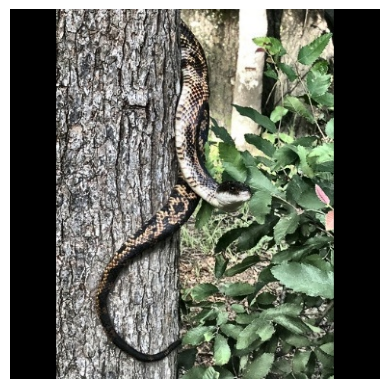

In [24]:
img, label = val_ds[10]
plt.imshow(img.permute(1, 2, 0).clamp(0, 1))
plt.axis('off')

actual_class_str = dataset.classes[label]           
predicted_class_str = predict_image(img, model)       

print('Label:', classe[actual_class_str], ', Predicted:', classe[predicted_class_str])

In [25]:
torch.save(model.state_dict(), 'snake-classi-cnn.pth')
